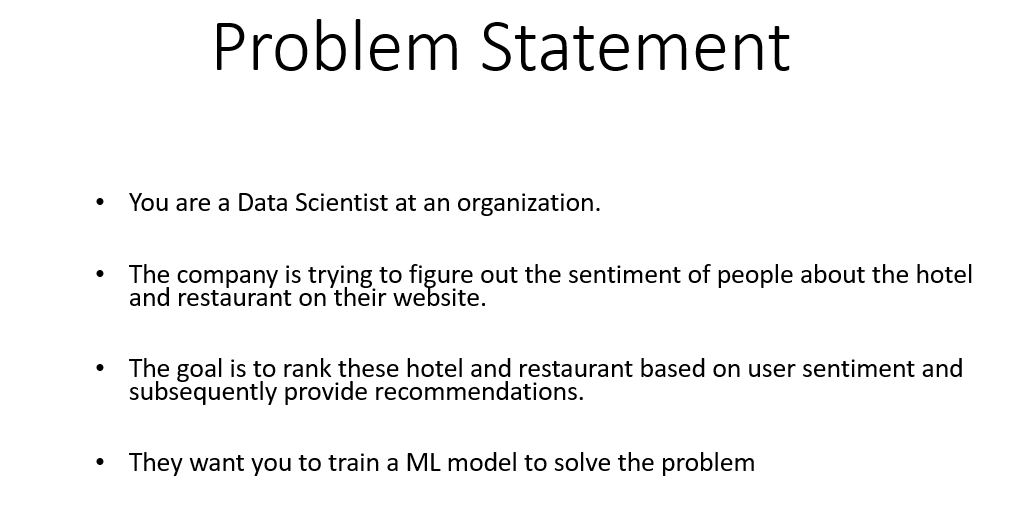

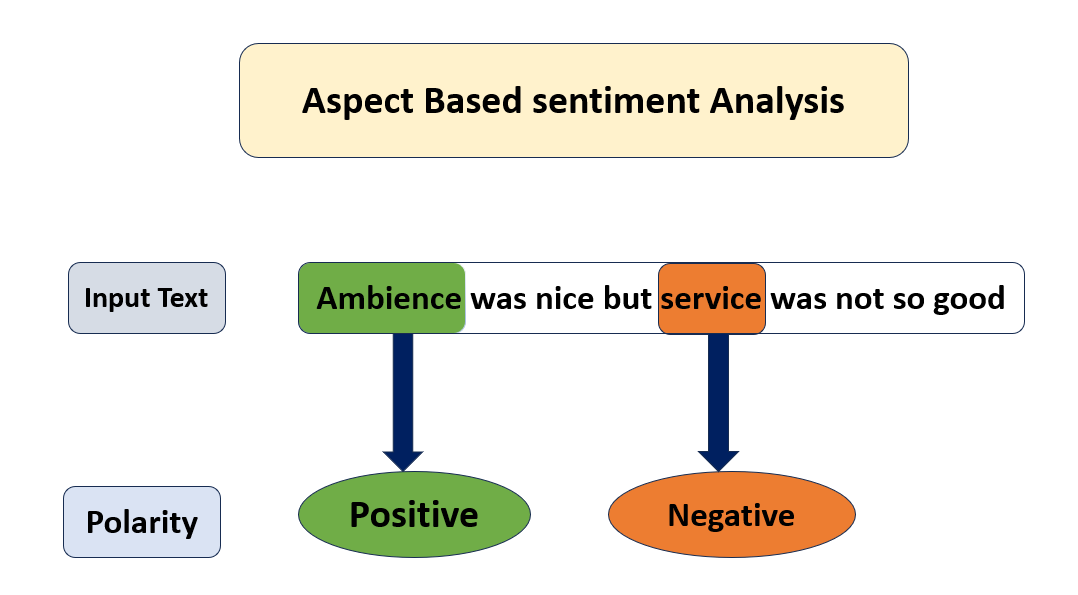

INPUT : { text : ‘food is delicious but price is high’,
Aspect: ‘food’}

OUTPUT: {Aspect sentiment: ‘Positive’}


In [1]:
import pandas as pd
import numpy as np
import re
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader
from sklearn.decomposition import PCA

In [2]:
import gensim.downloader as api
#model = api.load("glove-twitter-25")
model = api.load("glove-wiki-gigaword-100")

In [3]:
#Load glove word embedding vectors
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

# Mathematical representation of Attention

__Terminologies__
1. Key(K)
2. Query(Q)
3. Value(V)
4. Energy Function(a)
5. Alignment Distribution/Attention Weights(W)
6. Final Representation(Z)

### Step1 : Get Key Vector
### Step2 : Get Query Vector
### Step3 : Compute Energy/Attention score from Key and Query vector
### Step4 : Compute attention weight from attention score
### Step5 : Get Value vectors
### Step6 : Compute context vectors using attention weights and value vectors

# 1. Get Key Vector

#### Aspect based sentiment analysis problem

__Input Text__: Food is delicious but price is high.<br>
__Tokenized__: \[ 'food',  'is',  'delicious',  'but',  'price',  'is',  'high' \]<br>
__Key is simply the vector representation of the tokenized text__

vector representation is nothing but a word embedding model or output from recurrent model

In [6]:
sentences = [ 'food', 'is', 'delicious', 'but', 'price', 'is', 'high' ]
KEY = [glove_vectors[i].tolist() for i in sentences]
print(len(KEY[0]))
print(KEY[0][:10])

100
[-0.16485999524593353, 0.9199699759483337, 0.2273699939250946, -0.49031001329421997, -0.0018082000315189362, -0.33803001046180725, 0.05722099915146828, 0.14600999653339386, 0.40202000737190247, -0.2885800004005432]


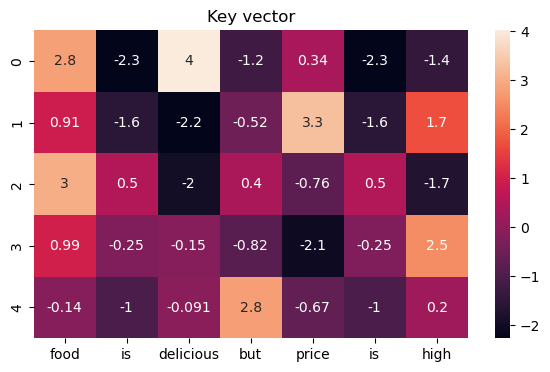

In [7]:
#Use Glove/W2V embedding and use pca on it with 5 components.
sentences = ['food','is','delicious','but','price','is','high']

#Dimentionality reduction for easy visualization
pca = PCA(n_components = 5)

#Key sequence
KEY = [glove_vectors[i].tolist() for i in sentences] #default 100 dim vector for each word
KEY = pca.fit_transform(KEY)

#plot
plt.figure(figsize = (7,4))
key_df = pd.DataFrame(np.transpose(np.matrix(KEY)), columns = sentences)
ax = sns.heatmap(key_df, annot = True).set_title('Key vector')

# 2. Get Query Vector

__It is basically the vector representation of the target.__<br>
Target: \['taste' ,  'cost'\]

Imagine we care about the price/cost.

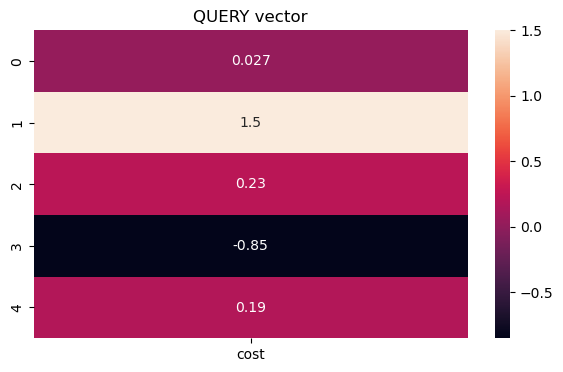

In [8]:
target = ['cost']
#query embedding and dimentionality reduction
QUERY = [glove_vectors[i].tolist() for i in target]
QUERY = pca.transform(QUERY)
#plot
plt.figure(figsize = (7,4))
key_df = pd.DataFrame(np.transpose(np.matrix(QUERY)), columns = target)
ax = sns.heatmap(key_df, annot = True).set_title('QUERY vector')

$\Large K_{d\times n}$<br>
$\Large Q_{d\times m}$

d = 5 -> word representation <br>
n = 7 -> sentence length<br>
m = 1 -> number of target

# 3. Compute energy function/attention function

Its basically multiplying key matrix with query matrix.
We will use dot product here

In [9]:
def compute_energy_function(vect, mat):
    # calculate attention_function
    return np.matmul(mat, np.transpose(vect),)

energy_score = compute_energy_function(QUERY, KEY)
energy_score

array([[ 1.26645121],
       [-2.29344564],
       [-3.59633899],
       [ 0.49175359],
       [ 6.39468926],
       [-2.29344564],
       [ 0.03033622]])

$\Large K_{d\times n}$<br>

$\Large Q_{d\times m}$<br>

$\Large K^T Q = n \times m$ 


# 4. Compute attention weights

__lets make the attention scores between 0 and 1__

### Formula of Attention(Q, K, V) =

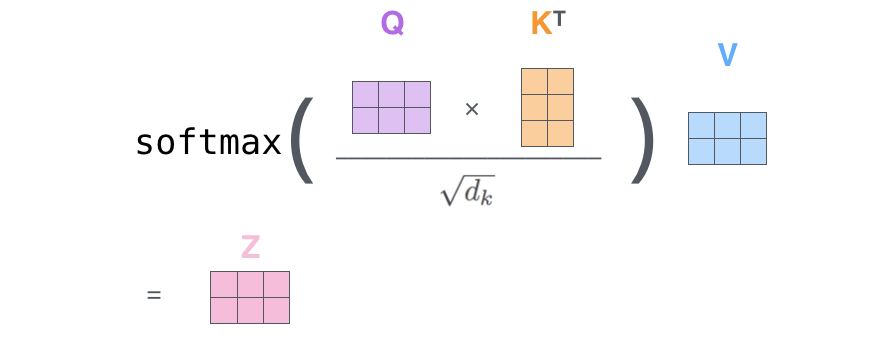

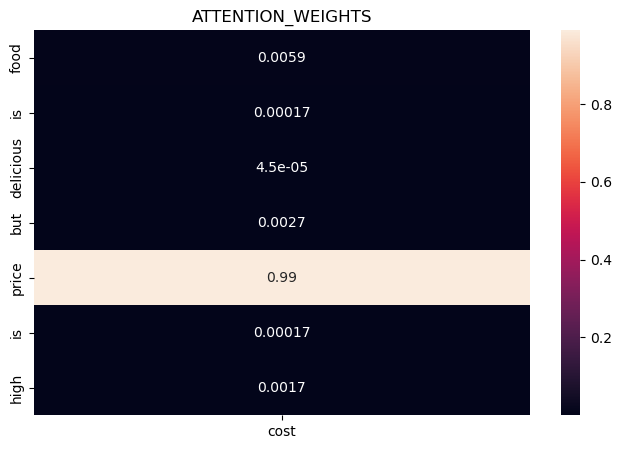

In [10]:
def softmax(x):
    x = np.array(x, dtype = np.float64)
    e_x = np.exp(x)
    return e_x/e_x.sum(axis = 0 )

ATTN_WEIGHTS = softmax(energy_score)
plt.figure(figsize = (8,5))
attention_df = pd.DataFrame(ATTN_WEIGHTS, index = sentences, columns = target)
ax = sns.heatmap(attention_df, annot = True).set_title('ATTENTION_WEIGHTS')


# Normalization

In [11]:
normalization_factor = np.sqrt(len(KEY))
energy_score = energy_score / normalization_factor

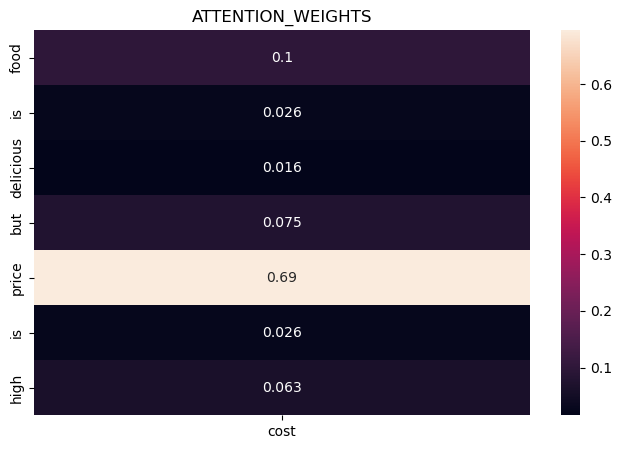

In [17]:
def softmax(x):
    x = np.array(x, dtype = np.float64)
    e_x = np.exp(x)
    return e_x/e_x.sum(axis = 0 )

ATTN_WEIGHTS = softmax(energy_score)
plt.figure(figsize = (8,5))
attention_df = pd.DataFrame(ATTN_WEIGHTS, index = sentences, columns = target)
ax = sns.heatmap(attention_df, annot = True).set_title('ATTENTION_WEIGHTS')


# Temperature

__How to control the diversity??__

So they applied a term "T" (or Theta) to the SoftMax function and in both the numerator and denominator wherever you see e^x_i, you replace it with e^(x_i / T).



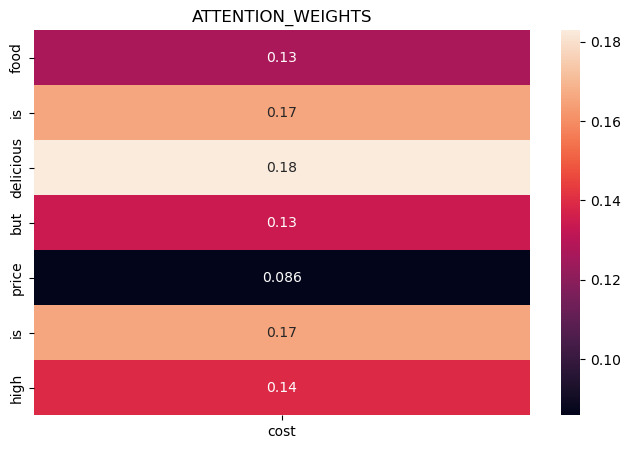

In [16]:
def softmax(x, temperature):
    x = np.array(x, dtype = np.float64)
    e_x = np.exp(x/temperature)
    return e_x/e_x.sum(axis = 0 )

temperature = -5
ATTN_WEIGHTS = softmax(energy_score, temperature)
plt.figure(figsize = (8,5))
attention_df = pd.DataFrame(ATTN_WEIGHTS, index = sentences, columns = target)
ax = sns.heatmap(attention_df, annot = True).set_title('ATTENTION_WEIGHTS')


What happens?<br>
* If T == 1: It's simply Softmax<br>

* If T > 1: It increases diversity in sampling giving chance to less likely tokens such as Cat because everyone loves an underdog winning story.<br>

* If T is between 0 and 1: It decreases diversity of sampling (not open to change)<br>

* Interestingly, if you make T < 0 which you shouldn't, it'll reverse the order of Logits and __price__ will have least probability and __is__ will have highest probability. <br>

* Of if T reaches infinity (very high) all words will have equal probability which is not practically useful and now you know why equality can’t be achieved and useful in life

# 5. Get Value vectors

Here Value = KEY

In [19]:
VALUE = np.matrix(KEY)
VALUE[:,1].reshape(1,-1).tolist()

[[0.9083230831317849,
  -1.575073951244784,
  -2.2435777088434423,
  -0.5155153865900152,
  3.2898335399047025,
  -1.5750739512447838,
  1.7110843748865365]]

# 6. Context Vector

We are finally multiplying probability distribution with VALUE vector(same as key vector here)

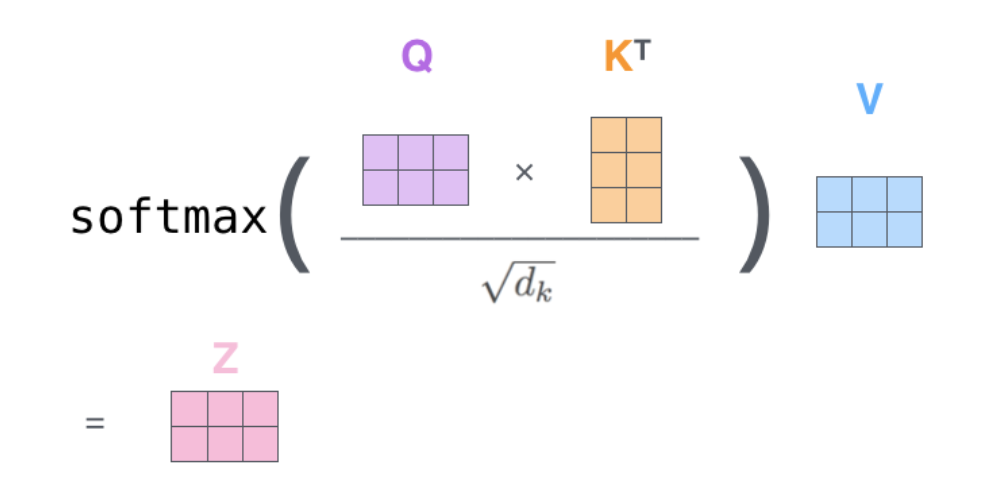

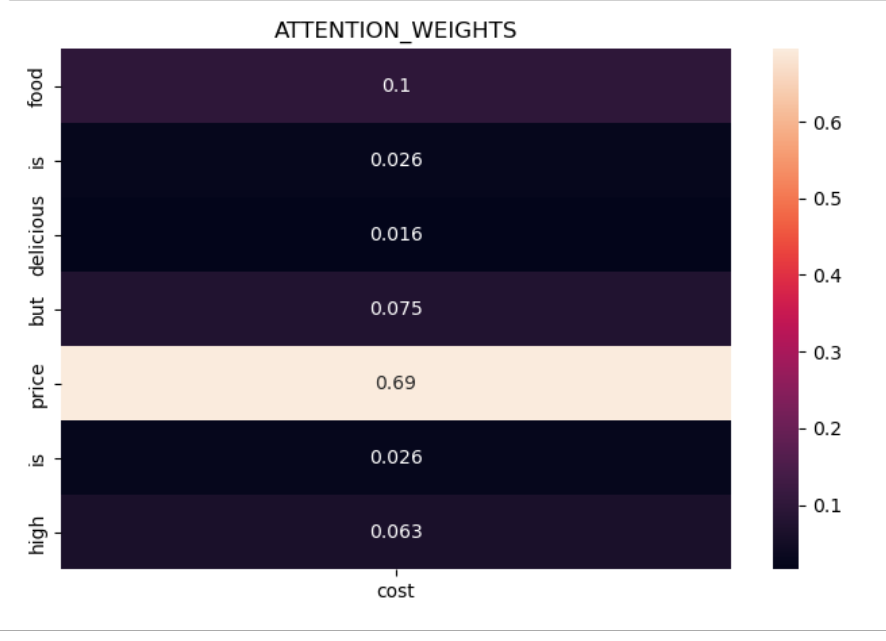
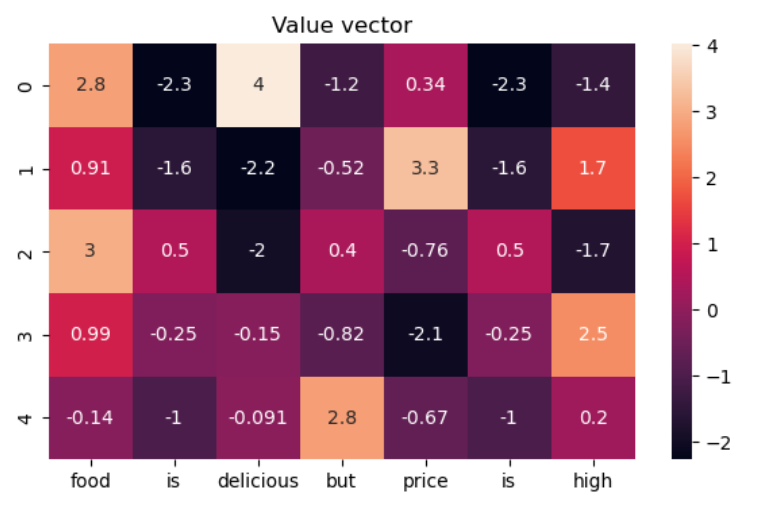


We are finally multiplying probability distribution with VALUE vector(same as key vector here)

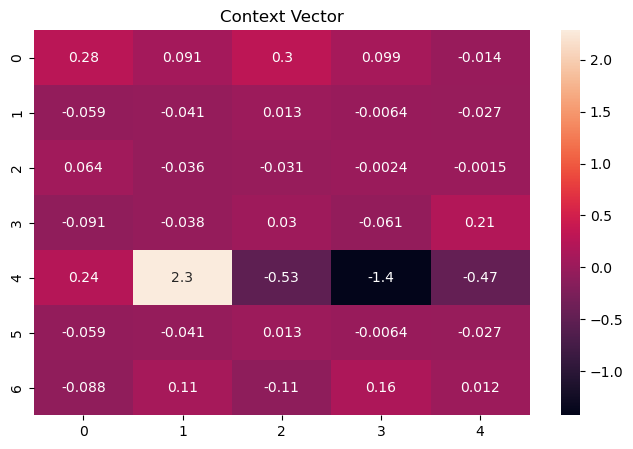

In [20]:
def apply_attention_scores(attentions_weights, annotations):
    #multiply the annotations by their attention weights
    return [annotations[:,i]*attentions_weights[i] for i in range(len(attentions_weights))]

applied_attention_1 = apply_attention_scores(ATTN_WEIGHTS, np.transpose(VALUE))
plt.figure(figsize = (8,5))
ax = sns.heatmap(np.array(applied_attention_1).reshape(7,5), annot = True).set_title('Context Vector')

# Types of Attention mechanism

__1. Distinctive Attention Mechanism__

KEY vector == Value Vector != Query Vector

__2. Self Attention__

QUERY == KEY == VALUE

Relate each word of the sentence with every other word in the same sentence so that each word can relate with every other word.

For each of the tokens when processing what are the other tokens I should focus on. 

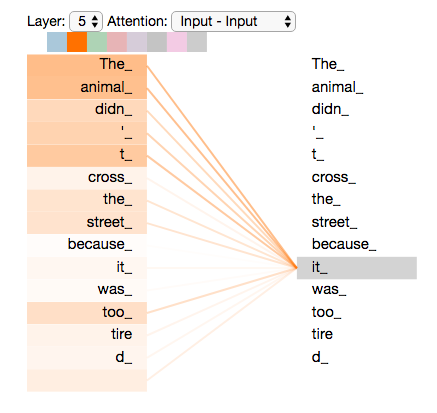

English: He is a good boy

German: er ist ein guter Junge

# Multi Head self attention

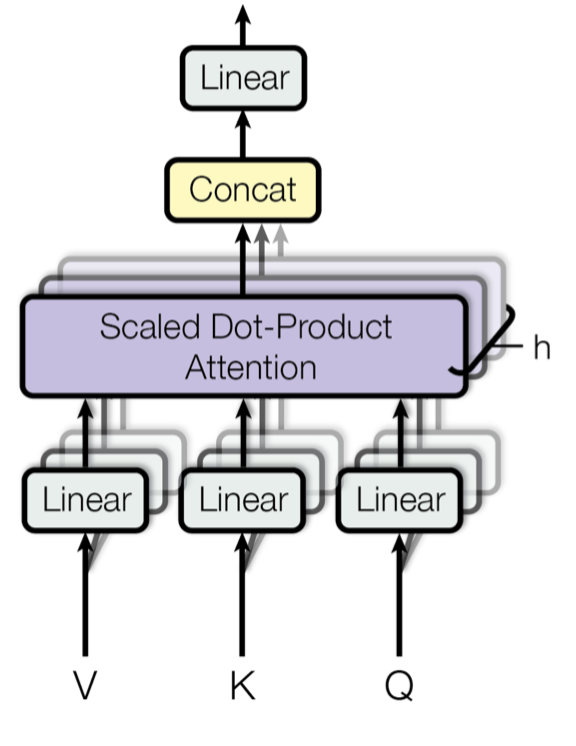

multi_head_attention splits the input Q, K, and V into multiple heads, performs scaled dot-product attention for each head, and then merges the results.

You are using many heads. means many K, V and Q matrix

# End

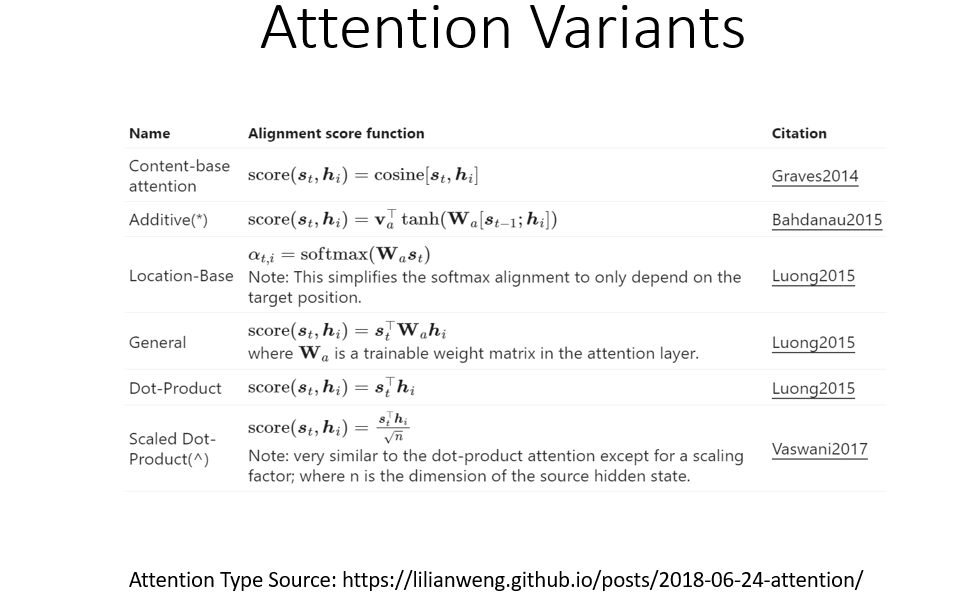